In [199]:
from collections import defaultdict
import numpy as np

minmax_x = [9999999999999, -9999999999999]
minmax_y = [9999999999999, -9999999999999]

pos_dic = defaultdict(lambda: [])
with open("data/dartfish/mouse1/DARTFISH_DecodedSpots_Mm_20190513.csv") as f:
    print(f.readline())
    for line in f:
        entries = line.rstrip().split(',')
        x = float(entries[1]) * .144
        y = float(entries[2]) * .144
        g = entries[0]
        if g == "Idh3a": # weird gene
            continue
        if g == "":
            continue
        pos_dic[g].append([x, y])
        if x < minmax_x[0]:
            minmax_x[0] = x
        if x > minmax_x[1]:
            minmax_x[1] = x
        if y < minmax_y[0]:
            minmax_y[0] = y
        if y > minmax_y[1]:
            minmax_y[1] = y
for g in pos_dic:
    pos_dic[g] = np.array(pos_dic[g])

target,x,y,distance,x_um,y_um,nucleus_label,dist2nucleus



In [200]:
all_genes = sorted(pos_dic.keys())
mrna_loci = [pos_dic[gene] for gene in all_genes]

In [201]:
minmax_x, minmax_y

([4.03594134912, 1219.39171848], [2.1621114374399997, 285.11915544])

In [202]:
width, height = 1240, 300

In [203]:
import ssam

In [204]:
ds = ssam.SSAMDataset(all_genes, mrna_loci, width, height)
analysis = ssam.SSAMAnalysis(ds, ncores=10, save_dir="data/dartfish_mouse1", verbose=True)

In [205]:
analysis.run_fast_kde(bandwidth=2.5, use_mmap=False, re_run=True)

Processing gene Malat1...
Processing gene Snap25...
Processing gene Slc1a2...
Processing gene Meg3...
Processing gene Plp1...
Processing gene Mef2c...
Processing gene Ndrg4...
Processing gene Ptgds...
Processing gene Stxbp1...
Processing gene Syt1...
Processing gene Prkcb...
Processing gene Snrpn...
Processing gene Sv2b...
Processing gene Fth1...
Processing gene Clstn1...
Processing gene Camk2n1...
Processing gene Nfib...
Processing gene Tspan7...
Processing gene Mapk1...
Processing gene App...
Processing gene Nsf...
Processing gene Fam171b...
Processing gene Slc1a3...
Processing gene Ncald...
Processing gene Osbpl1a...
Processing gene Rtn4...
Processing gene Sparcl1...
Processing gene Atp5a1...
Processing gene Gabra1...
Processing gene Dnm1...
Processing gene Gria1...
Processing gene Rtn3...
Processing gene Tuba1a...
Processing gene Atp1a3...
Processing gene Atp2b4...
Processing gene Tmsb4x...
Processing gene Pak1...
Processing gene Nrxn1...
Processing gene Ptprd...
Processing gene Pp

Processing gene Ndufa13...
Processing gene Bdnf...
Processing gene Spock3...
Processing gene Mgll...
Processing gene Blnk...
Processing gene Pcdh15...
Processing gene Gpr88...
Processing gene Mal2...
Processing gene Kcnip1...
Processing gene Lypd6...
Processing gene Hapln1...
Processing gene Grb14...
Processing gene Tnfaip8l3...
Processing gene Ankrd55...
Processing gene Tpbg...
Processing gene Tpm2...
Processing gene Fam84b...
Processing gene Ly86...
Processing gene Ly6c2...
Processing gene Kcnmb2...
Processing gene Lhx6...
Processing gene Gpr83...
Processing gene Nefl...
Processing gene C1qb...
Processing gene Chodl...
Processing gene Galnt14...
Processing gene Crtac1...
Processing gene Phlda1...
Processing gene Ctgf...
Processing gene Cox6a2...
Processing gene Cort...
Processing gene Col6a1...
Processing gene Col25a1...
Processing gene Itpka...
Processing gene Cx3cr1...
Processing gene Fndc5...
Processing gene Chrna2...
Processing gene Chrm2...
Processing gene Gja1...
Processing gen

In [206]:
import matplotlib.pyplot as plt

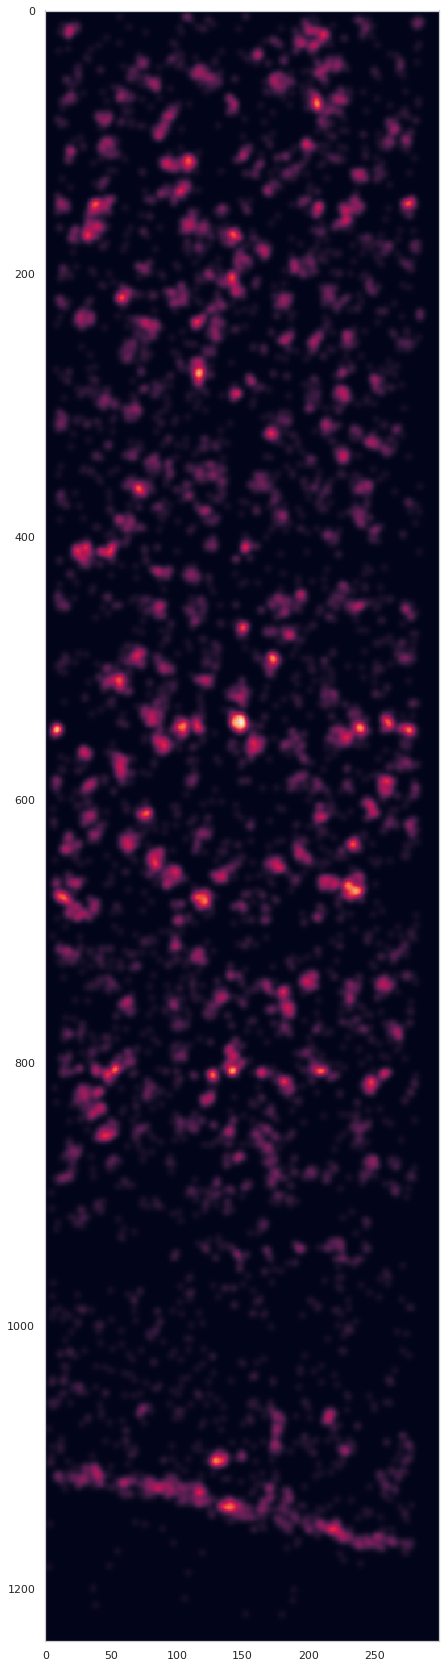

In [207]:
plt.figure(figsize=[10, 30])
plt.imshow(ds.vf_norm[..., 0])

In [208]:
exp_thres = 0
norm_thres = 0

In [209]:
analysis.find_localmax(search_size=3, min_expression=exp_thres, min_norm=norm_thres)

Found 1384 local max vectors.


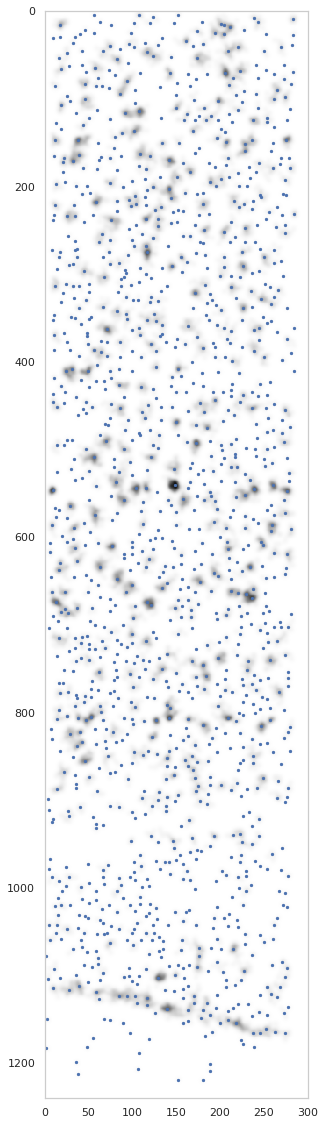

In [210]:
plt.figure(figsize=[10, 20])
ds.plot_l1norm(cmap="Greys")
ds.plot_localmax(s=5)

In [211]:
summed = []
for i in range(len(ds.genes)):
    summed.append(np.sum(ds.vf[ds.local_maxs][:, i]))

In [212]:
np.where(np.array(summed) == 0)

(array([], dtype=int64),)

In [213]:
analysis.normalize_vectors_sctransform(vst_kwargs=dict(min_cells=1))

In [261]:
analysis.cluster_vectors(pca_dims=33, resolution=0.15, max_correlation=0.05, metric="correlation", centroid_correction_threshold=0.6)

Found 19 clusters


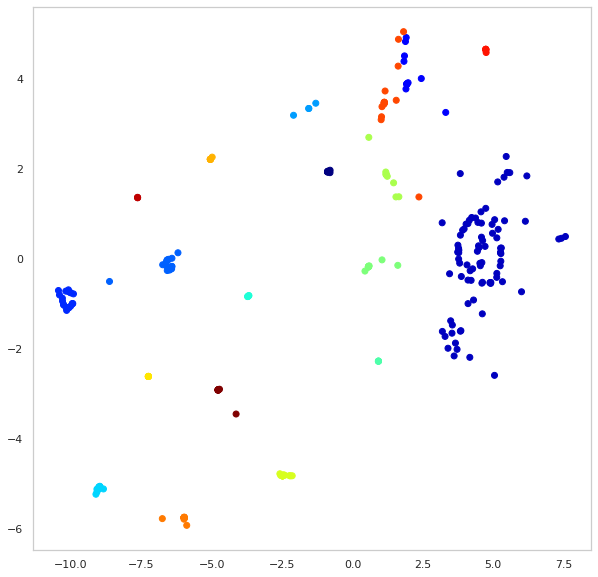

In [263]:
plt.figure(figsize=[10, 10])
ds.plot_tsne(run_tsne=True)

In [264]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=norm_thres+0.01, min_r=0.6)

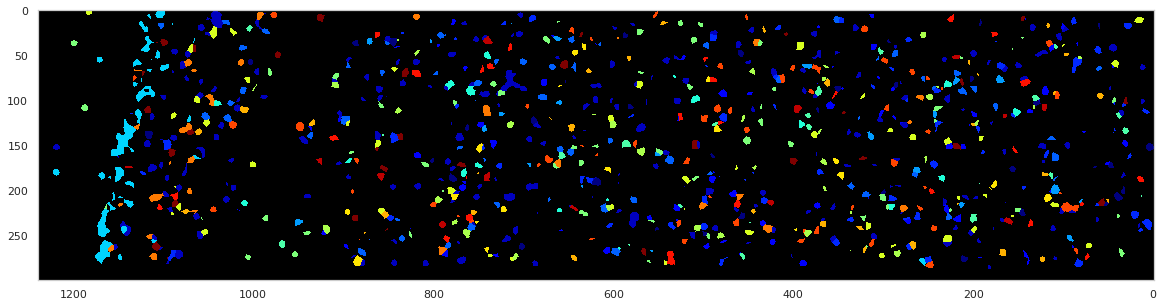

In [265]:
plt.figure(figsize=[20,12])
_=ds.plot_celltypes_map(rotate=True,)#colors=colors,background='white')#,set_alpha=True)

In [325]:
import pickle
with open("scrna_sigs.pkl", "rb") as f:
    scrna_cl_names, scrna_genes, scrna_full_centroids, scrna_colors = pickle.load(f)

In [326]:
gene_conv_dic ={
    "Ngfrap1": "Bex3",
    "Gucy1a3": "Gucy1a1",
    "Ppap2b": "Plpp3",
    "Selm": "Selenom",
}

In [327]:
for f, t in gene_conv_dic.items():
    scrna_genes = np.where(scrna_genes == f, t, scrna_genes)

In [328]:
scrna_genes_match_idx = [list(scrna_genes).index(g) for g in ds.genes]

In [329]:
scrna_centroids = scrna_full_centroids[:, scrna_genes_match_idx]

In [330]:
ssam_scrna_pcorrs = np.zeros((len(scrna_centroids), len(ds.centroids)))
for i, scrna_centroid in enumerate(scrna_centroids):
    for j, centroid in enumerate(ds.centroids):
        ssam_scrna_pcorrs[i, j] = ssam.utils.corr(scrna_centroid, centroid)

In [334]:
import os

In [335]:
from scipy.stats import pearsonr, spearmanr

diagdir = "diagplots_dartfish_mouse1"

if not os.path.exists(diagdir):
    os.mkdir(diagdir)

for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx, known_signatures=[
        ("scRNA-seq", scrna_cl_names, scrna_centroids, scrna_colors),
    ], correlation_methods=[
        ("r", pearsonr),
        ("rho", spearmanr)
    ])
    plt.tight_layout()
    plt.savefig(diagdir + '/diagplot_centroid_%d.png'%idx)
    plt.close()

In [336]:
analysis.map_celltypes(scrna_centroids)

In [337]:
analysis.filter_celltypemaps(min_norm=0.02, min_r=0.3)

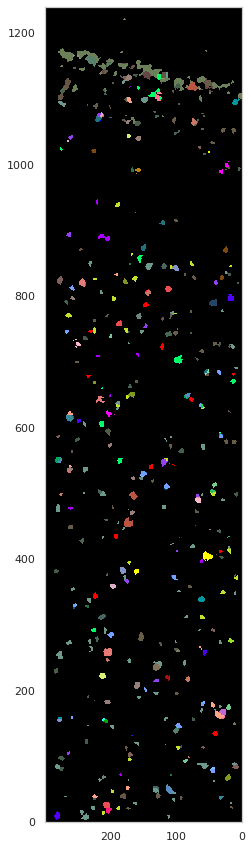

In [343]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,15])
_ = ds.plot_celltypes_map(rotate=2, colors=scrna_colors)

(0, 1240)

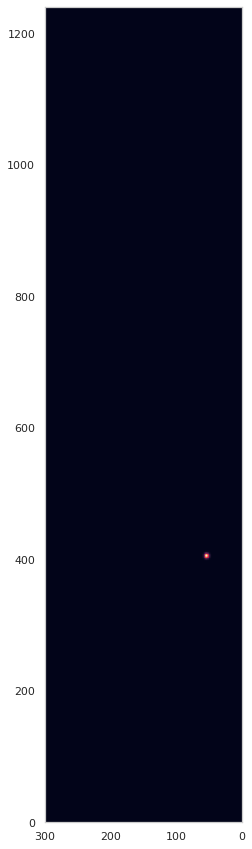

In [348]:
plt.figure(figsize=[10,15])
plt.imshow(ds.vf[...,0,ds.genes.index("Chodl")])
plt.xlim([ds.vf.shape[1], 0])
plt.ylim([0, ds.vf.shape[0]])

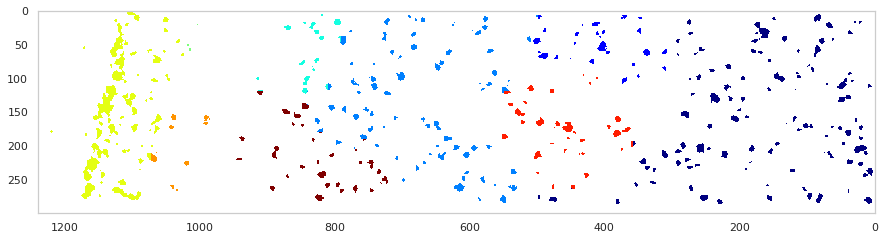

In [353]:
analysis.bin_celltypemaps(step=10, radius=100)
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.7, norm_thres=500)
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=1)